In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# for scikit-learn >= 0.18
from sklearn.model_selection import train_test_split

# for scikit-learn version <= 0.17
# from sklearn.cross_validation import train_test_split

%matplotlib inline

### Loading vehicles and non-vehicles images

Number of car images found :  8792
Number of non-car images found :  8968


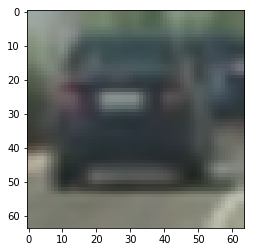

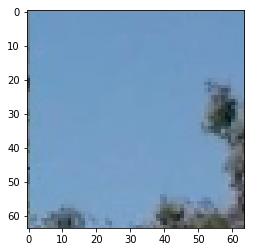

In [2]:
## Load images of vehicle and non-vehicle images

cars = glob.glob('C:/Temp/obj/vehicles/**/*.png')
notcars = glob.glob('C:/Temp/obj/non-vehicles/**/*.png')

print ('Number of car images found : ', len(cars))
print ('Number of non-car images found : ', len(notcars))

plt.figure()
plt.imshow(mpimg.imread(cars[0]))
plt.figure()
plt.imshow(mpimg.imread(notcars[0]))

#print (cars[0:5])
#print(notcars[0:5])

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img):
    global spatial_size

    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, spatial_size).ravel() 
    #plt.figure()
    #plt.plot(features)
    
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img):
    global hist_bins
    global hist_range
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=hist_bins, range=hist_range)
    channel2_hist = np.histogram(img[:,:,1], bins=hist_bins, range=hist_range)
    channel3_hist = np.histogram(img[:,:,2], bins=hist_bins, range=hist_range)
    #print (img[:,:,1])
    p = img[:,:,2]
    #print(np.min(p), np.max(p))
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    
    if(False):
        plt.figure()
        plt.imshow(img[:,:,1])
        plt.plot(channel2_hist[0])
        plt.subplot(131)
        plt.imshow(img[:,:,0])
        plt.subplot(132)
        plt.imshow(img[:,:,1])
        plt.subplot(133)
        plt.imshow(img[:,:,2])
        fig.tight_layout()
        plt.show()
        plt.figure()
        plt.subplot(131)
        plt.plot(channel1_hist[0])
        plt.subplot(132)
        plt.plot(channel2_hist[0])
        plt.subplot(133)
        plt.plot(channel3_hist[0])
        fig.tight_layout()
        plt.show()

    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, vis=False, feature_vec=True):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, block_norm= 'L2-Hys',
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, block_norm= 'L2-Hys',
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        #print("img", np.ptp(image,  axis=0))
        
        #print(file)
        # apply color conversion if other than 'RGB'
        if colorspace != 'RGB':
            if colorspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif colorspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif colorspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif colorspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif colorspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        # Apply bin_spatial() to get spatial color features
        #print("fet", np.ptp(feature_image,  axis=0))
        image_features.append(bin_spatial(feature_image))
        
        # Apply color_hist() also with a color space option now
        image_features.append(color_hist(feature_image))
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        image_features.append(hog_features)
        
        #### Append the new feature vector to the features list
        #features.append(hog_features)
        ####
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(image_features))
        
    # Return list of feature vectors
    return features

In [4]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

example_image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(example_image, cv2.COLOR_RGB2GRAY)


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(example_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

NameError: name 'orient' is not defined

In [5]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 100
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

spatial_size=(16, 16)
hist_bins=16
hist_range=(0.0, 1.0)
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# True = retrain and save, False = load from pickle
if(False):
    t=time.time()
    random.shuffle(cars)
    random.shuffle(notcars)
    car_features = extract_features(cars)
    notcar_features = extract_features(notcars)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Plot some graphs to show normilisation
    car_ind = np.random.randint(0, len(cars))
    scaled_X = X_scaler.transform(X)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    #Save to pickle
    print("Saving pickle")
    dist_pickle = {"svc":svc, "scaler":X_scaler, "orient":orient, "pix_per_cell":pix_per_cell, 
                   "cell_per_block":cell_per_block, "X_test":X_test[0:10], "y_test":y_test[0:10]}

    pickle.dump(dist_pickle, open("svc_pickle.p", "wb"))
    
else:    
    # Load from pickle
    print("Loading pickle")
    dist_pickle = pickle.load(open("svc_pickle.p", "rb" ))
    
    # get attributes of our svc object
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    #spatial_size = dist_pickle["spatial_size"]
    #hist_bins = dist_pickle["hist_bins"]
    X_test = dist_pickle["X_test"]
    y_test = dist_pickle["y_test"]
    
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Loading pickle
Test Accuracy of SVC =  1.0
My SVC predicts:  [0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
For these 10 labels:  [0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
0.0161 Seconds to predict 10 labels with SVC


In [24]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, spatial_feat=True, hist_feat=True, hog_feat=True):    
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than RGB
    # apply color conversion if other than 'RGB'
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler,  spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to draw bounding boxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=5):
    # Make a copy of the images
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with the boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel

    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list

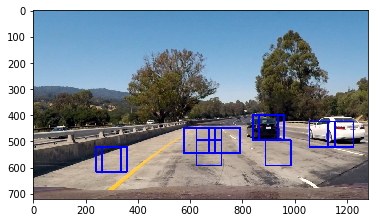

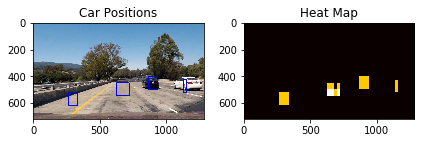

In [25]:
from scipy.ndimage.measurements import label

img = mpimg.imread('test_images/test1.jpg')
#img = img / 255.
ystart = 400
ystop = 656
scale = 1.5
#print(ystart, ystop, scale, svc, X_scaler)
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler)
plt.imshow(out_img)
    
heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


2.8012585639953613 seconds to process one image searching 350 windows
2.7413785457611084 seconds to process one image searching 350 windows
2.720994710922241 seconds to process one image searching 350 windows
2.7079601287841797 seconds to process one image searching 350 windows
2.861229181289673 seconds to process one image searching 350 windows
2.7514841556549072 seconds to process one image searching 350 windows


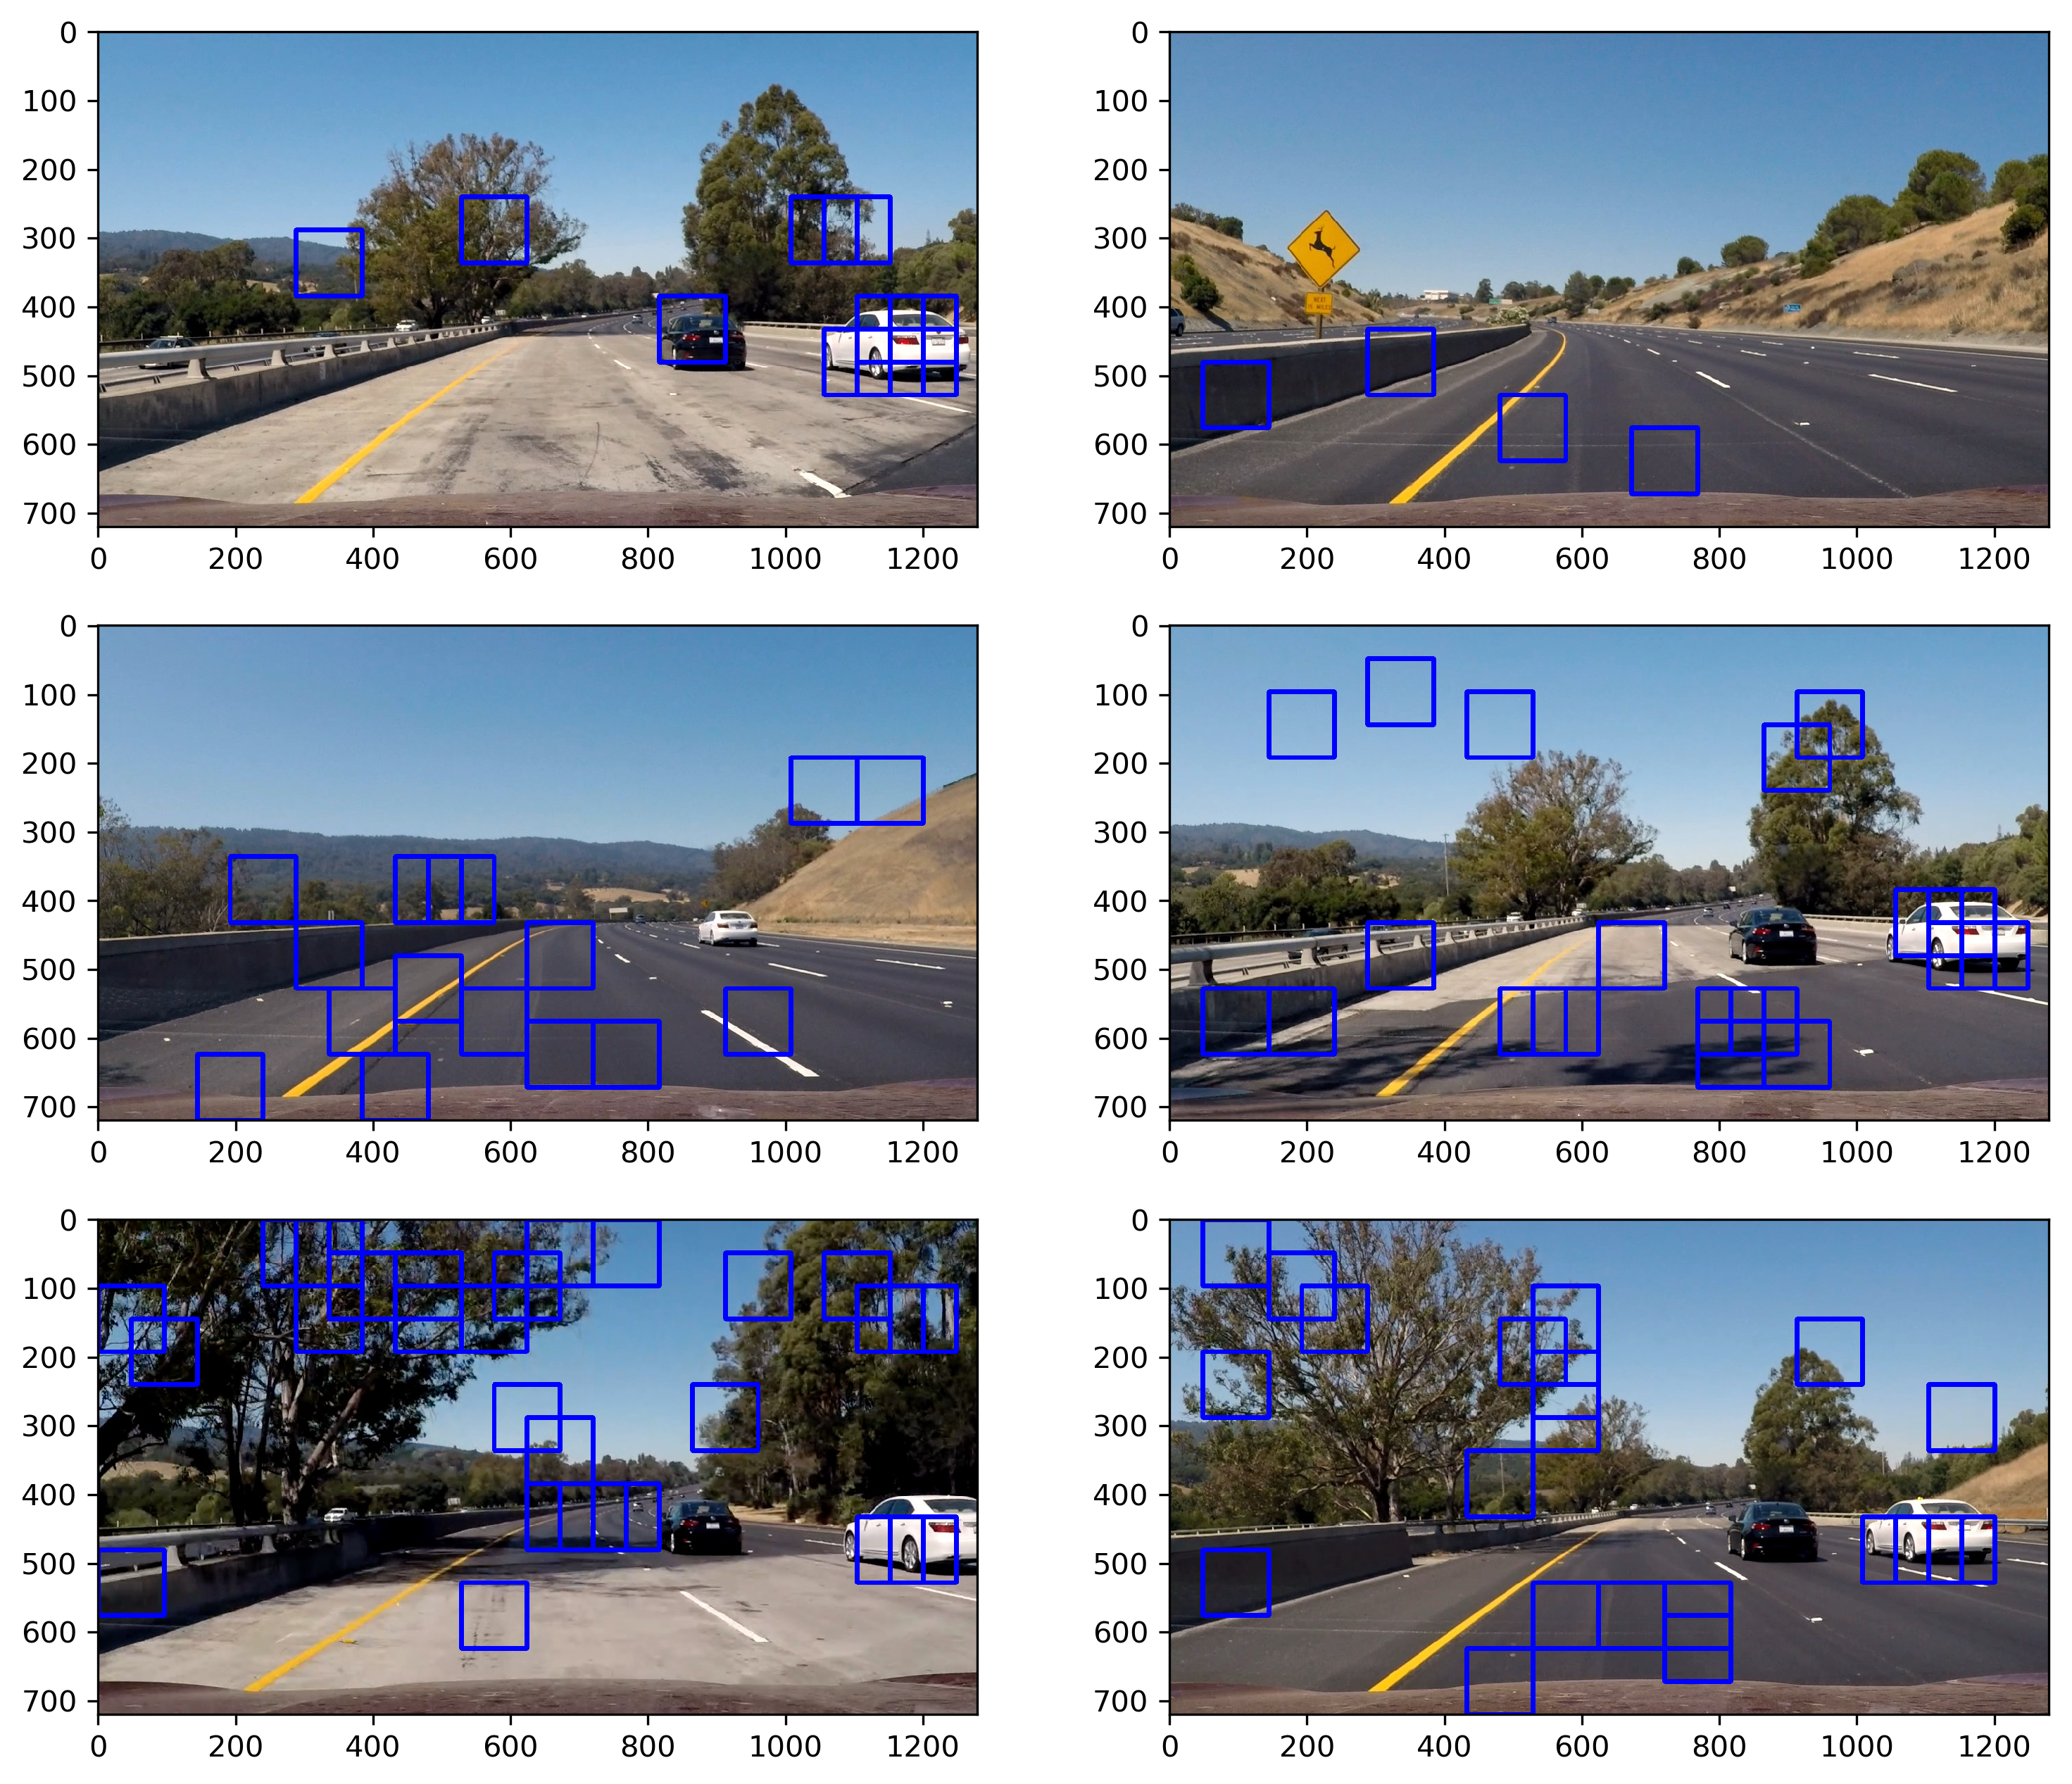

In [27]:
####### test

# Define a function for plotting multiple images
def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape) 
        if img_dims < 3:            
            plt.imshow(img, cmap='hot')                
            plt.title(titles[i])
        else:
            plt.imshow(img)                
            plt.title(titles[i])
            
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [None, None] # Min and max in y to search in slide_window()

overlap = 0.5

for img_src in example_images: 
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #print(np.min(img), np.max(img))

    #windows 
    windows = slide_window(img,x_start_stop=[None, None],y_start_stop=y_start_stop,
                          xy_window=(64,64),xy_overlap=(overlap,overlap))
    
    windows = slide_window(img,x_start_stop=[None, None],y_start_stop=y_start_stop,
                          xy_window=(96,96),xy_overlap=(overlap,overlap))
    
    #print(windows)
    #windows = window1 + window2 
    hot_windows = search_windows(img, windows, svc, X_scaler, 
                                 spatial_feat=True,
                                 hist_feat=True,
                                 hog_feat=True)
  
    window_img = draw_boxes(draw_img, hot_windows, color= (0,0,255),thick = 6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),'windows')

fig = plt.figure(figsize=(12,18),dpi=300)
visualize(fig,5,2,images,titles)

0.26548075675964355 seconds to run, total_windows = 6
0.2813417911529541 seconds to run, total_windows = 12
0.2813417911529541 seconds to run, total_windows = 18
0.2968435287475586 seconds to run, total_windows = 24
0.2968435287475586 seconds to run, total_windows = 30
0.2968435287475586 seconds to run, total_windows = 36
0.2968435287475586 seconds to run, total_windows = 42
0.31247639656066895 seconds to run, total_windows = 48
0.31247639656066895 seconds to run, total_windows = 54
0.31247639656066895 seconds to run, total_windows = 60
0.31247639656066895 seconds to run, total_windows = 66
0.3280956745147705 seconds to run, total_windows = 72
0.3280956745147705 seconds to run, total_windows = 78
0.3280956745147705 seconds to run, total_windows = 84
0.3280956745147705 seconds to run, total_windows = 90
0.3437204360961914 seconds to run, total_windows = 96
0.3437204360961914 seconds to run, total_windows = 102
0.3437204360961914 seconds to run, total_windows = 108
0.3437204360961914 sec

ValueError: num must be 1 <= num <= 16, not 17

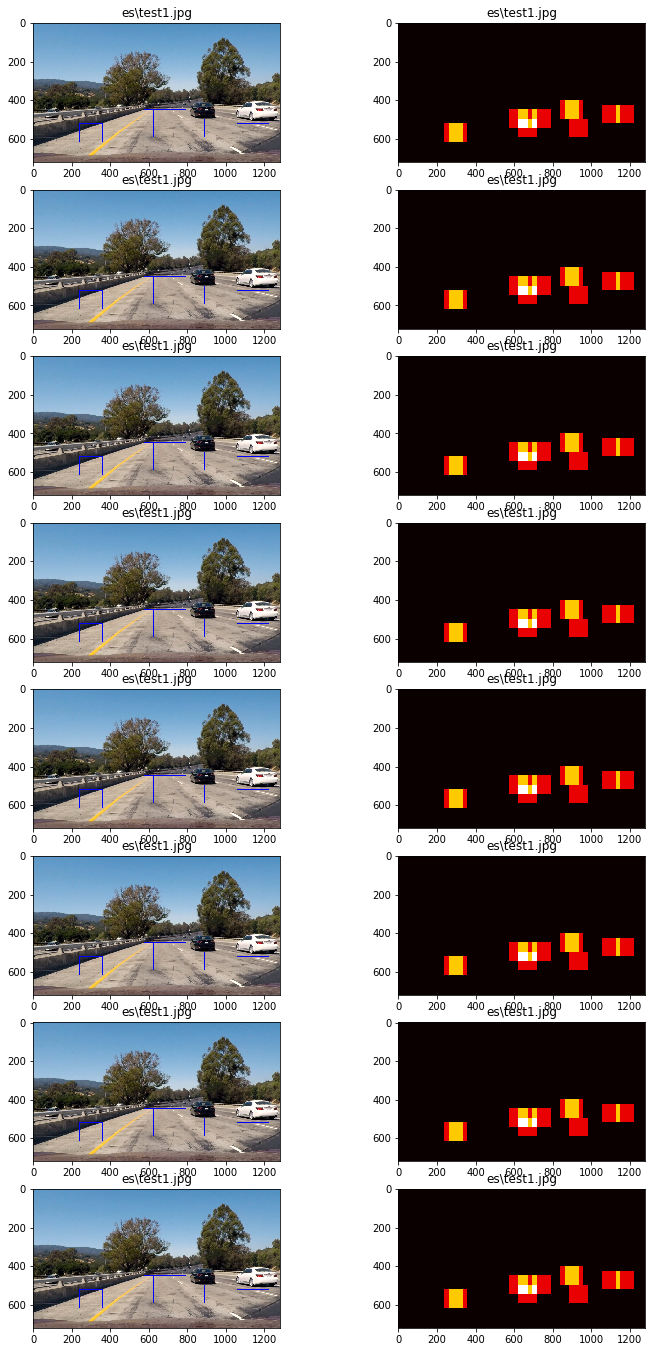

In [30]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swatch in y
ystart = 400
ystop = 656
scale = 1.5 

#Iterate over the test images 

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img  = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),
                                                      np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block **2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image 
    
    hog1 = get_hog_features(ch1,feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this Patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features= np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell 
            
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window],(64,64))
            
            # Get color features 
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1,-1))
            #test_features = X_scaler.trasnform(np.hstack((shape_fit,hist_feat)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw + ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
            
        #print(time.time()-t, 'seconds to run, total_windows =', count)
        
        out_images.append(draw_img)
        
        out_titles.append(img_src[-12:])
        
        #heatmap = 255*heatmap/np.max(heatmap)
        out_images.append(heatmap)
        out_maps.append(heatmap)
        out_boxes.append(img_boxes)

    fig = plt.figure(figsize=(12,24))       
    visualize(fig,8,2,out_images,out_titles)